This guide shows how to train and infer [Clay Foundation Model](https://clay-foundation.github.io/model/index.html) for segmentation task ([Chesapeake Land Cover
](https://lila.science/datasets/chesapeakelandcover)) using our API.

<a target="_blank" href="https://colab.research.google.com/github/bluesightai/docs/blob/main/guides/train-a-land-segmentation.ipynb">
  <img noZoom src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
API_URL = "https://api.bluesight.ai"

GSD = 1.0
CHIP_SIZE = 224
COLLECTION = "naip"
BANDS = ["red", "green", "blue", "nir"]

DATA_DIR = "./data"
N_TRAIN_SAMPLES = 1000
N_TEST_SAMPLES = 100

RANDOM_SEED = 42
HEADERS = {"Content-Type": "application/json"}

In [ ]:
!pip install awscli

## Loading data



In [ ]:
!aws s3 cp s3://us-west-2.opendata.source.coop/agentmorris/lila-wildlife/lcmcvpr2019/cvpr_chesapeake_landcover/ny_1m_2013_extended-debuffered-train_tiles/ data/train/ --recursive --no-sign-request --region us-west-2 --exclude "*" --include "*_lc.tif" --include "*_naip-new.tif"
!aws s3 cp s3://us-west-2.opendata.source.coop/agentmorris/lila-wildlife/lcmcvpr2019/cvpr_chesapeake_landcover/ny_1m_2013_extended-debuffered-val_tiles/ data/val/ --recursive --no-sign-request --region us-west-2 --exclude "*" --include "*_lc.tif" --include "*_naip-new.tif"

## Processing data

https://github.com/Clay-foundation/model/blob/main/finetune/segment/preprocess_data.py

In [2]:
import os
import re
from pathlib import Path

import numpy as np
import rasterio as rio
from tqdm import tqdm

In [ ]:
DATA_DIR = Path(DATA_DIR)
OUTPUT_DIR = DATA_DIR / "output"

def read_and_chip(file_path, chip_size, output_dir):
    """
    Reads a GeoTIFF file, creates chips of specified size, and saves them as
    numpy arrays.

    Args:
        file_path (str or Path): Path to the GeoTIFF file.
        chip_size (int): Size of the square chips.
        output_dir (str or Path): Directory to save the chips.
    """
    os.makedirs(output_dir, exist_ok=True)

    with rio.open(file_path) as src:
        data = src.read()

        n_chips_x = src.width // chip_size
        n_chips_y = src.height // chip_size

        chip_number = 0
        for i in range(n_chips_x):
            for j in range(n_chips_y):
                x1, y1 = i * chip_size, j * chip_size
                x2, y2 = x1 + chip_size, y1 + chip_size

                chip = data[:, y1:y2, x1:x2]
                chip_path = os.path.join(
                    output_dir,
                    f"{Path(file_path).stem}_chip_{chip_number}.npy",
                )
                np.save(chip_path, chip)
                chip_number += 1


def process_files(file_paths, output_dir, chip_size):
    """
    Processes a list of files, creating chips and saving them.

    Args:
        file_paths (list of Path): List of paths to the GeoTIFF files.
        output_dir (str or Path): Directory to save the chips.
        chip_size (int): Size of the square chips.
    """
    for file_path in tqdm(file_paths):
        read_and_chip(file_path, chip_size, output_dir)
        

train_image_paths = list((DATA_DIR / "train").glob("*_naip-new.tif"))
train_label_paths = list((DATA_DIR / "train").glob("*_lc.tif"))
val_image_paths = list((DATA_DIR / "val").glob("*_naip-new.tif"))
val_label_paths = list((DATA_DIR / "val").glob("*_lc.tif"))

process_files(train_image_paths, OUTPUT_DIR / "train/chips", CHIP_SIZE)
process_files(train_label_paths, OUTPUT_DIR / "train/labels", CHIP_SIZE)
process_files(val_image_paths, OUTPUT_DIR / "val/chips", CHIP_SIZE)
process_files(val_label_paths, OUTPUT_DIR / "val/labels", CHIP_SIZE)

In [4]:
train_chip_names = [chip_path.name for chip_path in list((OUTPUT_DIR / "train/chips").glob("*.npy"))]
train_label_names = [re.sub("_naip-new_", "_lc_", chip) for chip in train_chip_names]

val_chip_names = [chip_path.name for chip_path in list((OUTPUT_DIR / "val/chips").glob("*.npy"))]
val_label_names = [re.sub("_naip-new_", "_lc_", chip) for chip in val_chip_names]

In [5]:
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 15: 6}

X_train = [{
    "gsd": GSD,
    "bands": BANDS,
    "pixels": np.load(OUTPUT_DIR / "train/chips" / chip_name).tolist(),
    "platform": COLLECTION
} for chip_name in tqdm(train_chip_names[:N_TRAIN_SAMPLES])]
y_train = [{"label": np.vectorize(label_mapping.get)(np.load(OUTPUT_DIR / "train/labels" / chip_name).squeeze()).tolist()} for chip_name in tqdm(train_label_names[:N_TRAIN_SAMPLES])]
#y_train = [{"label": np.load(OUTPUT_DIR / "train/labels" / chip_name).squeeze().tolist()} for chip_name in tqdm(train_label_names[:N_TRAIN_SAMPLES])]

X_test = [{
    "gsd": GSD,
    "bands": BANDS,
    "pixels": np.load(OUTPUT_DIR / "val/chips" / chip_name).tolist(),
    "platform": COLLECTION
} for chip_name in tqdm(val_chip_names[:N_TEST_SAMPLES])]
y_test = [{"label": np.vectorize(label_mapping.get)(np.load(OUTPUT_DIR / "val/labels" / chip_name).squeeze()).tolist()} for chip_name in tqdm(val_label_names[:N_TEST_SAMPLES])]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.67it/s]


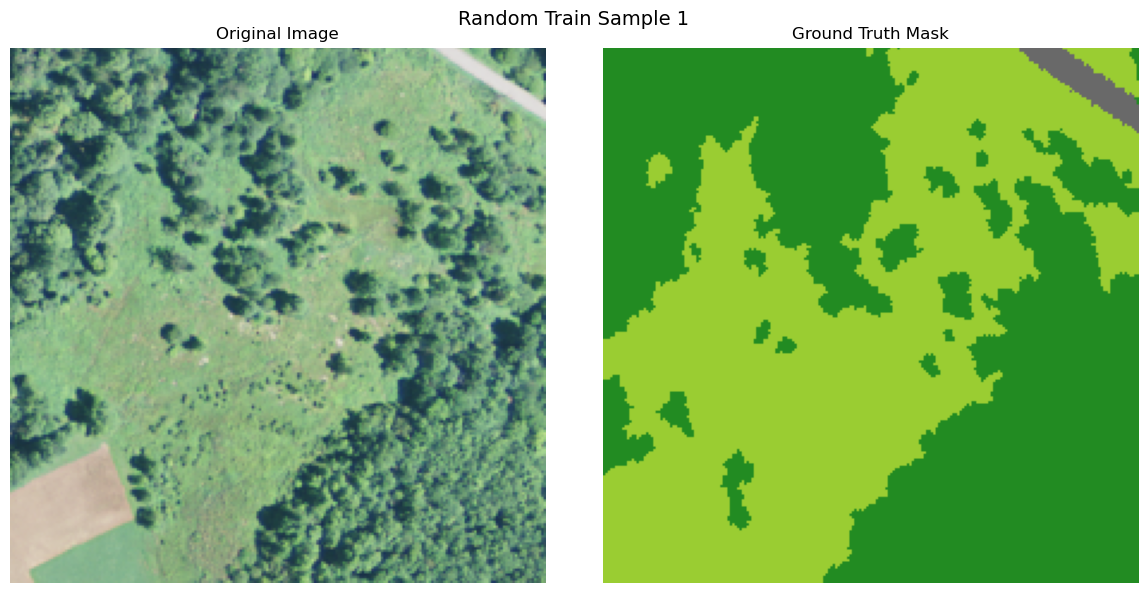

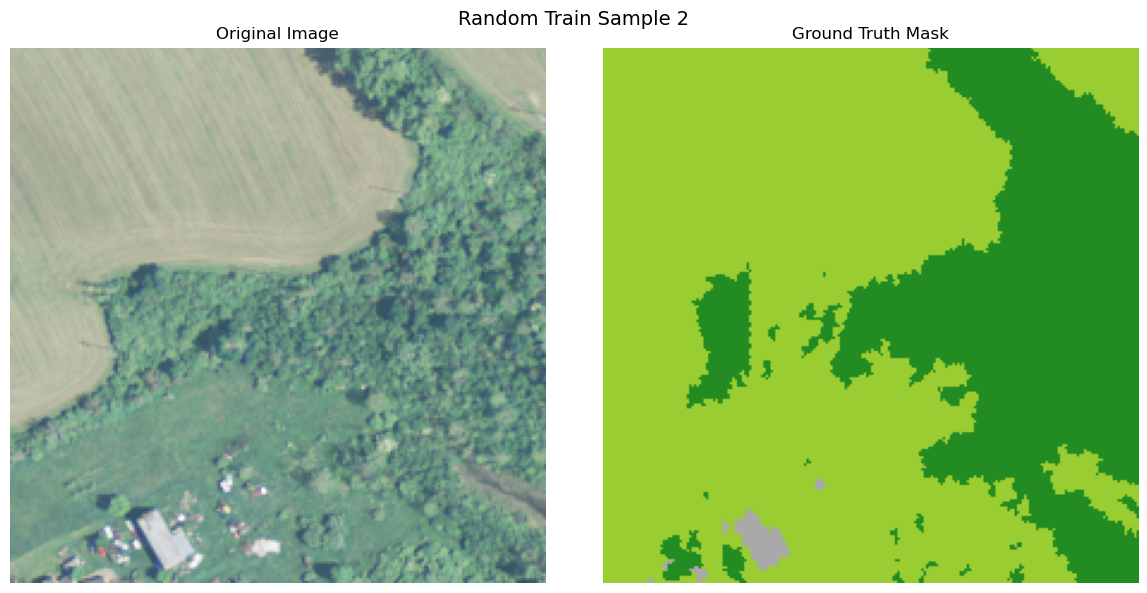

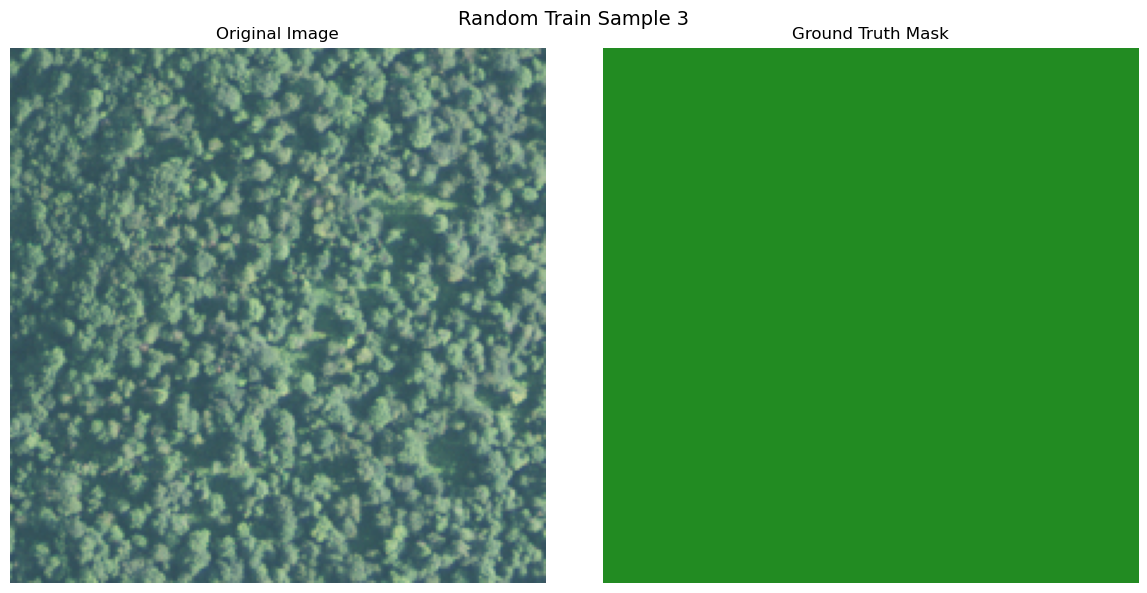

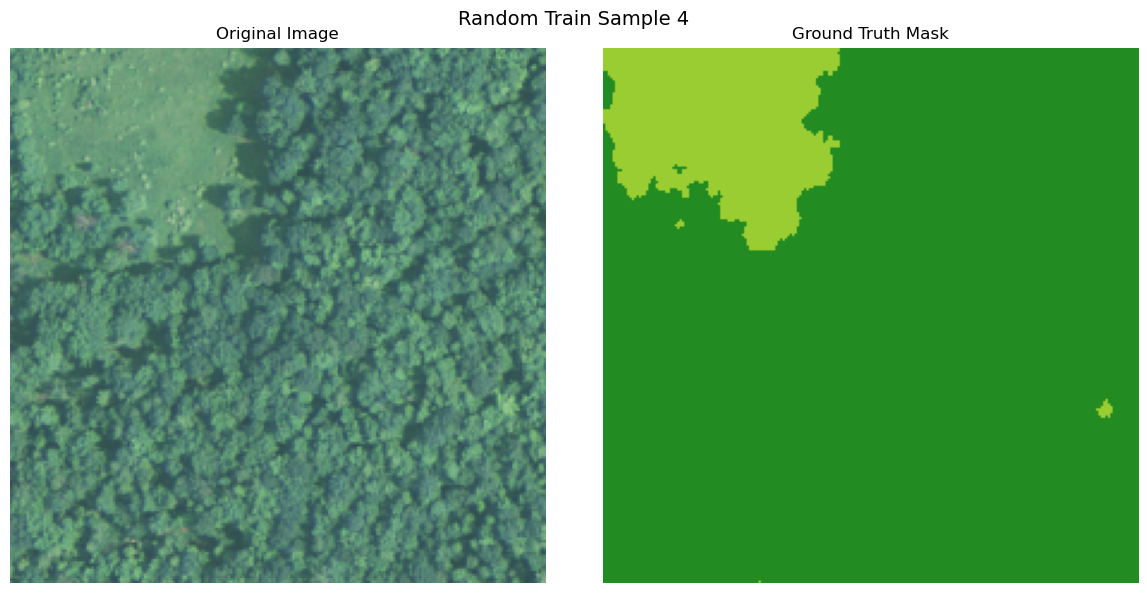

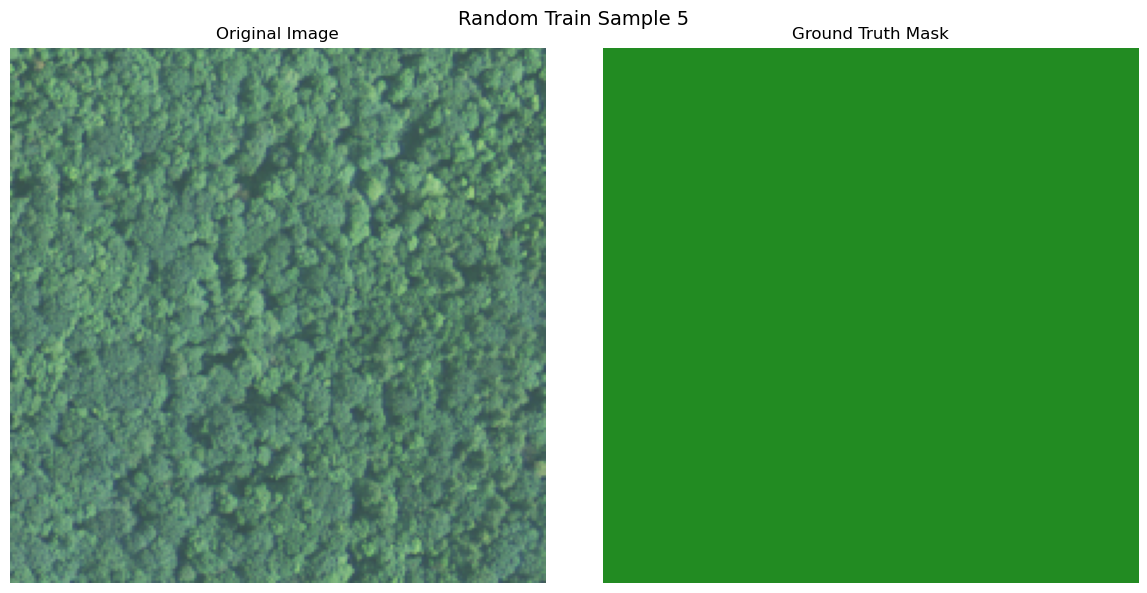

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_image_mask_pair(image, true_mask, pred_mask=None, title="Image and Mask Comparison"):
    color_map = {
        0: (0, 0, 255),     # Deep Blue for water
        1: (34, 139, 34),   # Forest Green for tree canopy / forest
        2: (154, 205, 50),  # Yellow Green for low vegetation / field
        3: (210, 180, 140), # Tan for barren land
        4: (169, 169, 169), # Dark Gray for impervious (other)
        5: (105, 105, 105), # Dim Gray for impervious (road)
        6: (255, 255, 255), # White for no data
    }

    def create_colored_mask(mask):
        colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                colored_mask[i, j] = color_map[mask[i, j]]
        return colored_mask

    true_colored_mask = create_colored_mask(true_mask)
    
    n_cols = 3 if pred_mask is not None else 2
    
    fig_width = 6 * n_cols
    fig_height = 6
    fig, axes = plt.subplots(1, n_cols, figsize=(fig_width, fig_height))
    
    if n_cols == 2:
        axes = [axes[0], axes[1]]
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(true_colored_mask)
    axes[1].set_title("Ground Truth Mask", fontsize=12)
    axes[1].axis('off')
    
    if pred_mask is not None:
        pred_colored_mask = create_colored_mask(pred_mask)
        axes[2].imshow(pred_colored_mask)
        axes[2].set_title("Predicted Mask", fontsize=12)
        axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


random_indices = np.random.choice(len(X_train), 5, replace=False)

for i, idx in enumerate(random_indices):
    image = np.array(X_train[idx]['pixels']).transpose(1, 2, 0)
    true_mask = np.array(y_train[idx]['label'])
    
    if image.shape[2] > 3:
        image = image[:, :, :3]
    
    visualize_image_mask_pair(image=image, true_mask=true_mask, title=f"Random Train Sample {i+1}")

## Train model

Now we need to load data to the format which is accepted by our API. Essentially, it is raw pixels data from all bands with some metadata.

You can check detailed endpoint specification [in the docs](https://docs.bluesight.ai/api-reference/train/train-segmentation-model).

In [7]:
import requests

url = API_URL + "/train/segmentation"
payload = {"images": X_train, "labels": y_train}
response = requests.request("POST", url, json=payload, headers=HEADERS)
if response.status_code != 200:
    print(f"{response.status_code}: {response.json()}")
else:
    data = response.json()
    model_id, train_details = data["model_id"], data["train_details"]
    print(f"Model id: '{model_id}'")

Model id: 'checkpoints/segmentation/1000_bXRqH.ckpt'


## Run inference

For inference we need only images.

You can check detailed endpoint specification [in the docs](https://docs.bluesight.ai/api-reference/inference/infer-segmentation-model).

In [8]:
url = API_URL + "/inference/segmentation"
payload = {"images": X_test, "model_id": model_id}
response = requests.request("POST", url, json=payload, headers=HEADERS)
if response.status_code != 200:
    print(f"{response.status_code}: {response.json()}")
else:
    y_pred = response.json()["labels"]

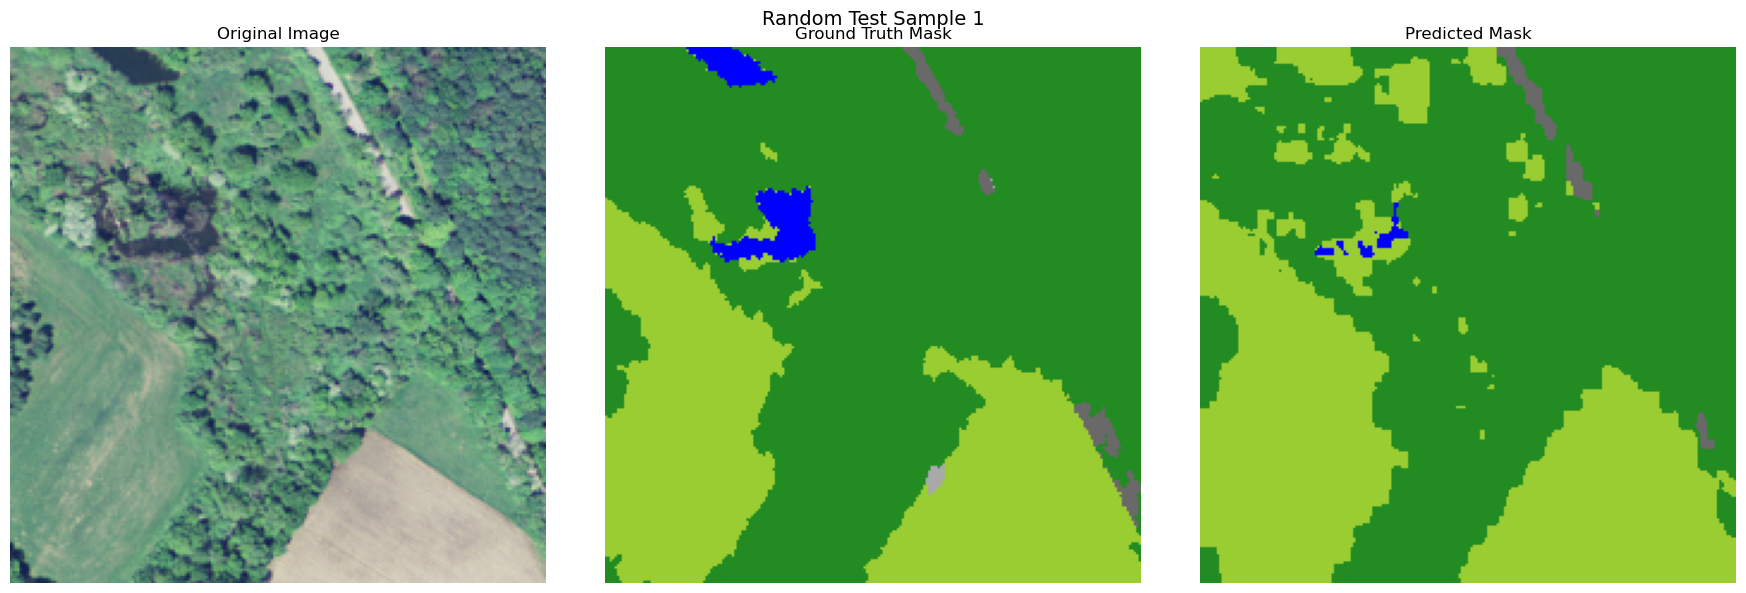

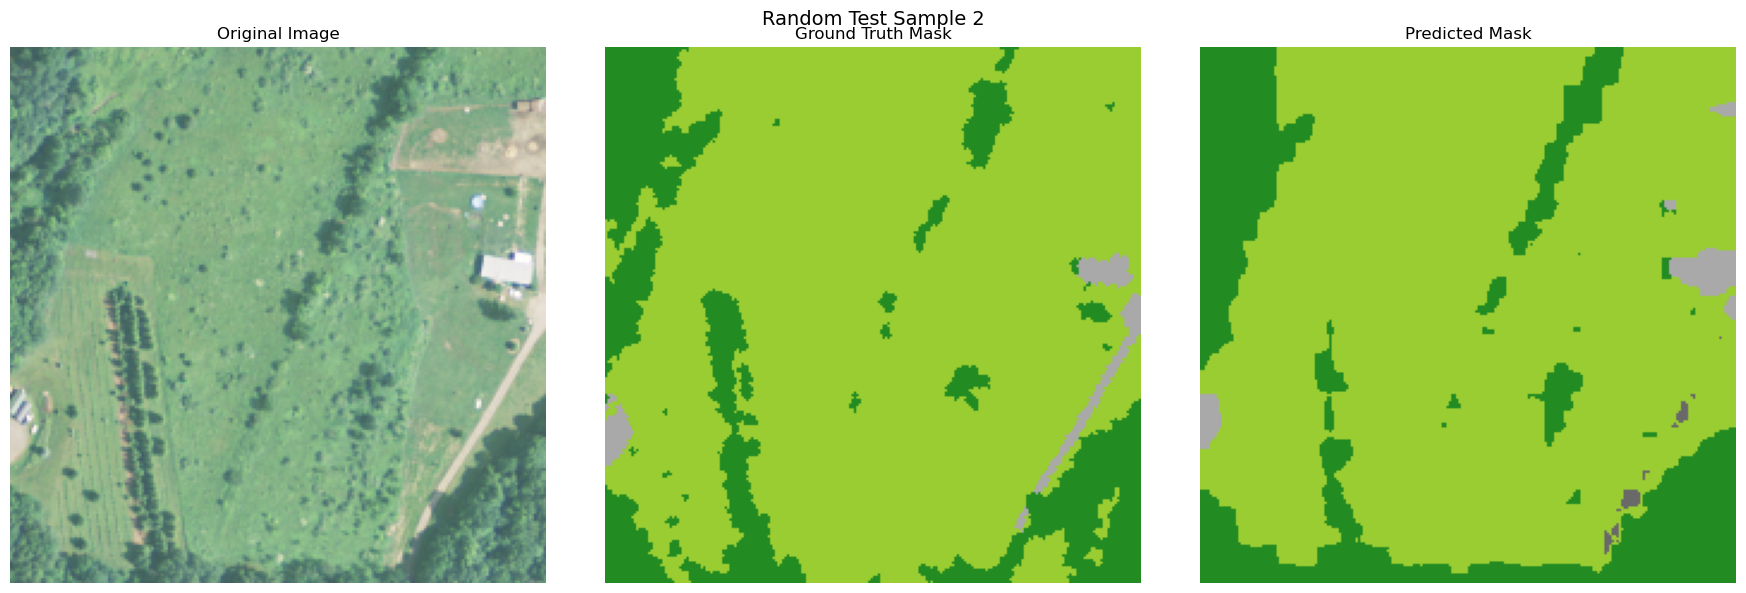

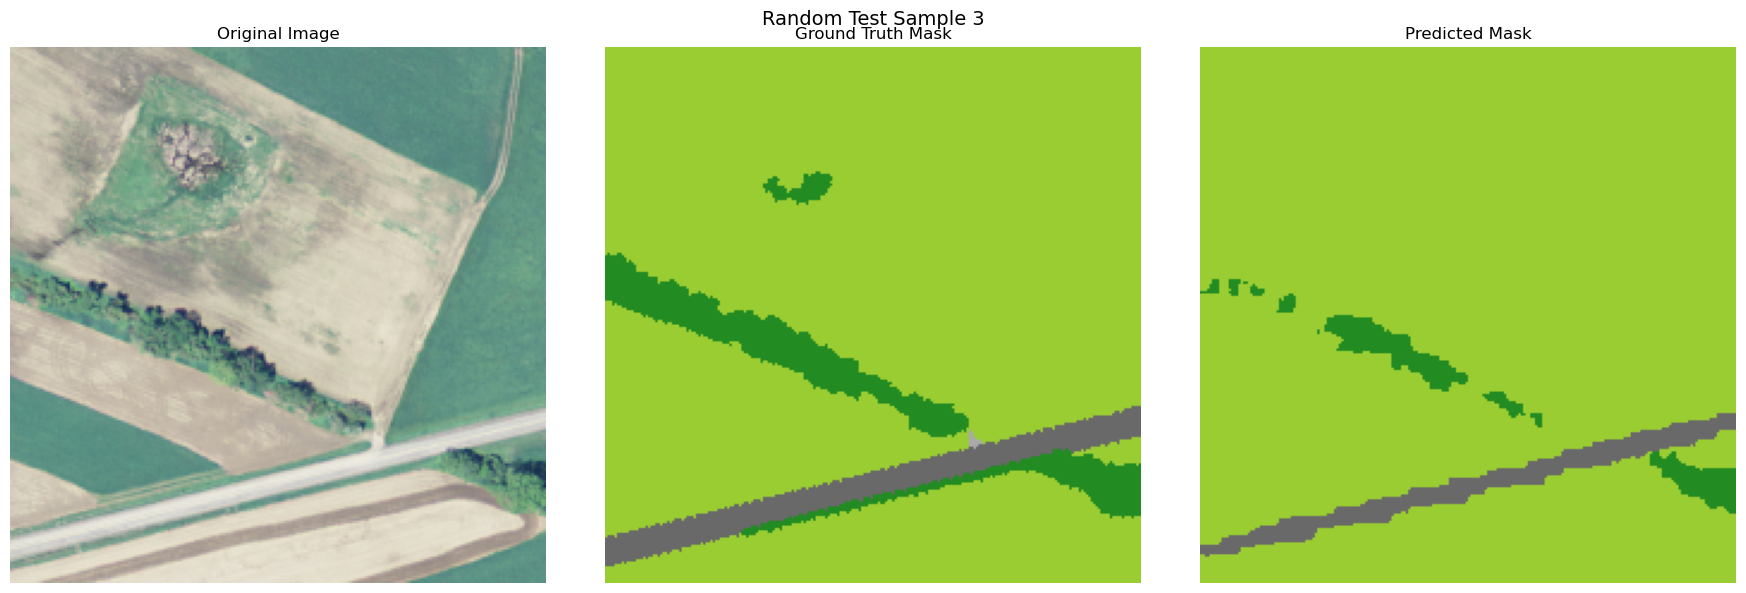

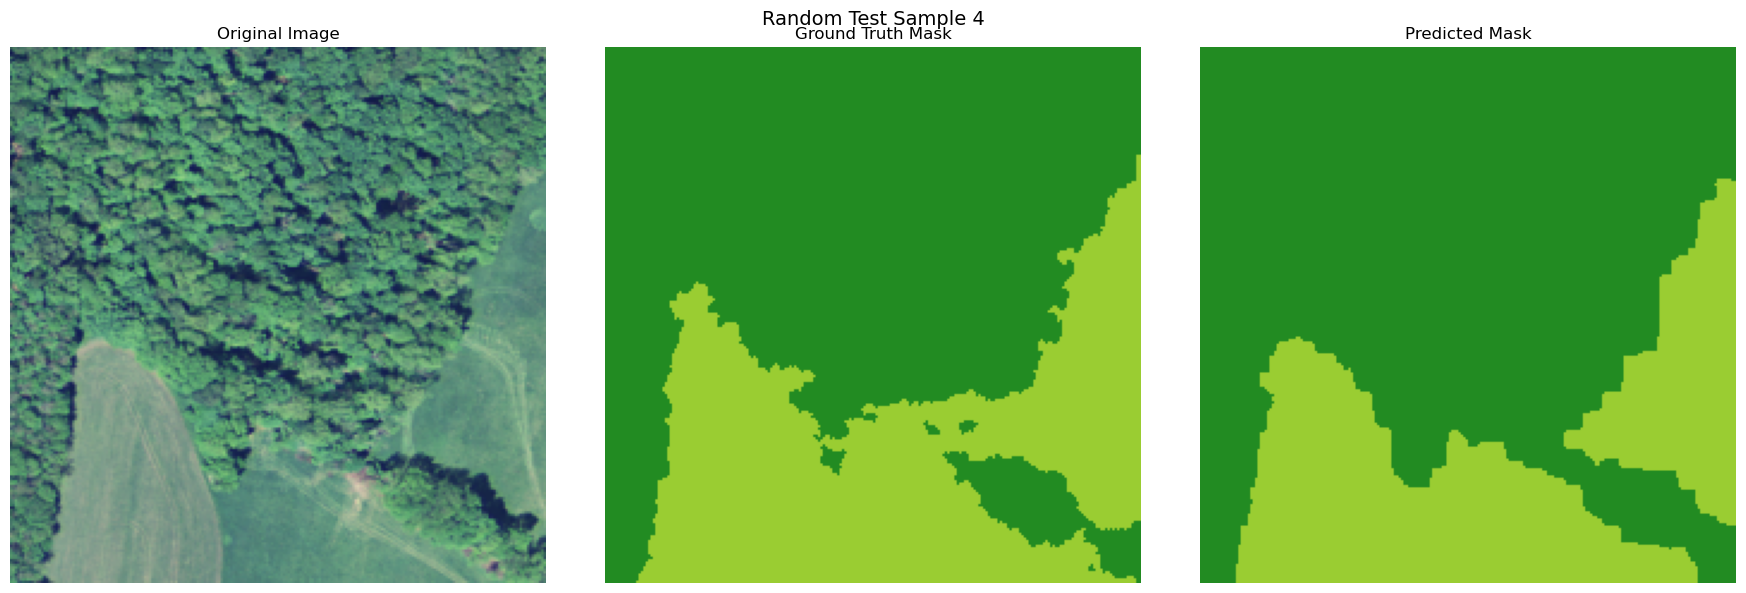

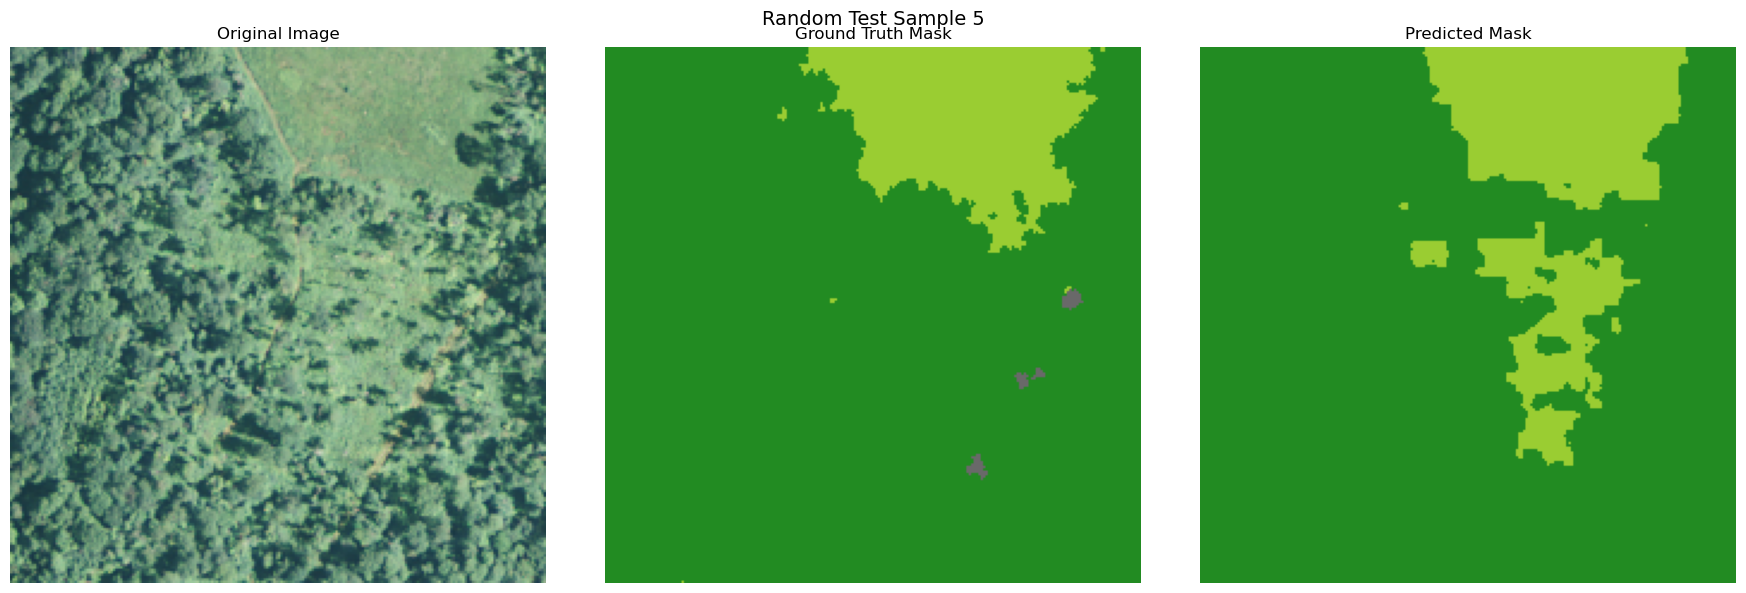

In [9]:
random_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(random_indices):
    image = np.array(X_test[idx]['pixels']).transpose(1, 2, 0)
    true_mask = np.array(y_test[idx]['label'])
    pred_mask = np.array(y_pred[idx]['label'])
    
    if image.shape[2] > 3:
        image = image[:, :, :3]
    
    visualize_image_mask_pair(image=image, true_mask=true_mask, pred_mask=pred_mask, title=f"Random Test Sample {i+1}")

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def calculate_segmentation_metrics(y_true, y_pred):
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    pixel_accuracy = accuracy_score(y_true_flat, y_pred_flat)
    
    mean_iou = jaccard_score(y_true_flat, y_pred_flat, average='macro')
    
    precision = precision_score(y_true_flat, y_pred_flat, average='macro')
    recall = recall_score(y_true_flat, y_pred_flat, average='macro')
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
    
    return {
        'confusion_matrix': cm,
        'pixel_accuracy': pixel_accuracy,
        'mean_iou': mean_iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

metrics = calculate_segmentation_metrics(np.array([item["label"] for item in y_test]), np.array([item["label"] for item in y_pred]))

for metric, value in metrics.items():
    print(f"{metric}:")
    print(value)
    print()

/home/furiousteabag/.local/share/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion_matrix:
[[ 160804    4886   15125       0    8121    1584]
 [     97 2459924  121413       0     968    2991]
 [    341  134154 1952005       0    6040    2595]
 [      0      23   27950       0    3427       0]
 [     56    1295   16542       0   27946    5000]
 [      0    3422   18340       0    2546   40005]]

pixel_accuracy:
0.9248812181122449

mean_iou:
0.5842388518958763

precision:
0.6975933274932938

recall:
0.6498189323285697

f1_score:
0.671332330422049

